<a href="https://colab.research.google.com/github/Momilijaz96/AlphaFold-V1-PyTorch/blob/main/AlphaFold1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Data Downloading 

In [ ]:
# Download weights and test data
!if [ ! -f alphafold-casp13-weights.zip ]; then wget -O alphafold-casp13-weights.zip http://bit.ly/alphafold-casp13-weights; fi;
!if [ ! -f t0949.zip ]; then wget -O t0949.zip https://www.dropbox.com/s/mnezcygg80qxq94/T0949.zip?dl=1; fi;

# Unzip files
!if [ ! -d alphafold-casp13-weights ]; then unzip -a alphafold-casp13-weights.zip -d alphafold-casp13-weights; fi;
!if [ ! -d alphafold-casp13-data ]; then unzip -a t0949.zip -d alphafold-casp13-data; fi;

--2021-04-14 00:15:38--  http://bit.ly/alphafold-casp13-weights
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://storage.googleapis.com/alphafold_casp13_data/alphafold_casp13_weights.zip [following]
--2021-04-14 00:15:38--  https://storage.googleapis.com/alphafold_casp13_data/alphafold_casp13_weights.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 172.217.203.128, 142.250.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218839215 (209M) [application/zip]
Saving to: ‘alphafold-casp13-weights.zip’

alphafold-casp13-we 100%[===================>] 208.70M  39.8MB/s    in 5.2s    

2021-04-14 00:15:44 (39.8 MB/s) - ‘alphafold-casp13-weights.zip’ saved [218839215/218839215]

--2021-04-14 00:15:44--

In [ ]:
!pip install dm-sonnet

     |████████████████████████████████| 256kB 4.4MB/s 


In [ ]:
import tensorflow as tf
import numpy as np
import IPython.display as display

import os, sys

# Feature Loading

In [ ]:
NUM_RES = 'sequence_length_placeholder' 
FEATURES = {
    'aatype': ('float32', [NUM_RES, 21]),
    'alpha_mask': ('int64', [NUM_RES, 1]),
    'alpha_positions': ('float32', [NUM_RES, 3]),
    'beta_mask': ('int64', [NUM_RES, 1]),
    'beta_positions': ('float32', [NUM_RES, 3]),
    'between_segment_residues': ('int64', [NUM_RES, 1]),
    'chain_name': ('string', [1]),
    'deletion_probability': ('float32', [NUM_RES, 1]),
    'domain_name': ('string', [1]),
    'gap_matrix': ('float32', [NUM_RES, NUM_RES, 1]),
    'hhblits_profile': ('float32', [NUM_RES, 22]),
    'hmm_profile': ('float32', [NUM_RES, 30]),
    #'key': ('string', [1]),
    'mutual_information': ('float32', [NUM_RES, NUM_RES, 1]),
    'non_gapped_profile': ('float32', [NUM_RES, 21]),
    'num_alignments': ('int64', [NUM_RES, 1]),
    'num_effective_alignments': ('float32', [1]),
    'phi_angles': ('float32', [NUM_RES, 1]),
    'phi_mask': ('int64', [NUM_RES, 1]),
    'profile': ('float32', [NUM_RES, 21]),
    'profile_with_prior': ('float32', [NUM_RES, 22]),
    'profile_with_prior_without_gaps': ('float32', [NUM_RES, 21]),
    'pseudo_bias': ('float32', [NUM_RES, 22]),
    'pseudo_frob': ('float32', [NUM_RES, NUM_RES, 1]),
    'pseudolikelihood': ('float32', [NUM_RES, NUM_RES, 484]),
    'psi_angles': ('float32', [NUM_RES, 1]),
    'psi_mask': ('int64', [NUM_RES, 1]),
    'residue_index': ('int64', [NUM_RES, 1]),
    'resolution': ('float32', [1]),
    'reweighted_profile': ('float32', [NUM_RES, 22]),
    'sec_structure': ('int64', [NUM_RES, 8]),
    'sec_structure_mask': ('int64', [NUM_RES, 1]),
    'seq_length': ('int64', [NUM_RES, 1]),
    'sequence': ('string', [1]),
    'solv_surf': ('float32', [NUM_RES, 1]),
    'solv_surf_mask': ('int64', [NUM_RES, 1]),
    'superfamily': ('string', [1]),
}

**Analysis:**
 Each file has tfrec/contacts/rr/pickle file in it.<br>
 Tfrec is the features for model input.<br>
 rr is predicted contact map derived from distogram.<br>
 pickle file contains predicted distogram.<br>
 contents/ files in this are for utility.<br>

 the "key" feature needed to be commented out since it caused issues. Maybe its non-existant in the data?

In [ ]:
FEATURE_TYPES = {k: v[0] for k, v in FEATURES.items()}
FEATURE_SIZES = {k: v[1] for k, v in FEATURES.items()}

def shape(feature_name, num_residues, features=None):
  """Get the shape for the given feature name.
  Args:
    feature_name: String identifier for the feature. If the feature name ends
      with "_unnormalized", theis suffix is stripped off.
    num_residues: The number of residues in the current domain - some elements
      of the shape can be dynamic and will be replaced by this value.
    features: A feature_name to (tf_dtype, shape) lookup; defaults to FEATURES.
  Returns:
    List of ints representation the tensor size.
  """
  features = features or FEATURES
  if feature_name.endswith('_unnormalized'):
    feature_name = feature_name[:-13]

  unused_dtype, raw_sizes = features[feature_name]
  replacements = {NUM_RES: num_residues}

  sizes = [replacements.get(dimension, dimension) for dimension in raw_sizes]
  return sizes


def parse_tfexample(raw_data, features):
  """Read a single TF Example proto and return a subset of its features.
  Args:
    raw_data: A serialized tf.Example proto.
    features: A dictionary of features, mapping string feature names to a tuple
      (dtype, shape). This dictionary should be a subset of
      protein_features.FEATURES (or the dictionary itself for all features).
  Returns:
    A dictionary of features mapping feature names to features. Only the given
    features are returned, all other ones are filtered out.
  """
  feature_map = {
      k: tf.io.FixedLenSequenceFeature(shape=(), dtype=v[0], allow_missing=True)
      for k, v in features.items()
  }
  parsed_features = tf.io.parse_single_example(raw_data, feature_map)

  # Find out what is the number of sequences and the number of alignments.
  num_residues = tf.cast(parsed_features['seq_length'][0], dtype=tf.int32)

  # Reshape the tensors according to the sequence length and num alignments.
  for k, v in parsed_features.items():
    new_shape = shape(feature_name=k, num_residues=num_residues)
    # Make sure the feature we are reshaping is not empty.
    assert_non_empty = tf.assert_greater(
        tf.size(v), 0, name='assert_%s_non_empty' % k,
        message='The feature %s is not set in the tf.Example. Either do not '
        'request the feature or use a tf.Example that has the feature set.' % k)
    with tf.control_dependencies([assert_non_empty]):
      parsed_features[k] = tf.reshape(v, new_shape, name='reshape_%s' % k)

  return parsed_features


def create_tf_dataset(tf_record_filename, features):
  """Creates an instance of tf.data.Dataset backed by a protein dataset SSTable.
  Args:
    tf_record_filename: A string with filename of the TFRecord file.
    features: A list of strings of feature names to be returned in the dataset.
  Returns:
    A tf.data.Dataset object. Its items are dictionaries from feature names to
    feature values.
  """
  # Make sure these features are always read.
  required_features = ['aatype', 'sequence', 'seq_length']
  features = list(set(features) | set(required_features))
  features = {name: FEATURES[name] for name in features}

  tf_dataset = tf.data.TFRecordDataset(filenames=[tf_record_filename])
  tf_dataset = tf_dataset.map(lambda raw: parse_tfexample(raw, features))

  return tf_dataset

In [ ]:
# Load single example from data set
tf_record_filename = 'alphafold-casp13-data/T0949/T0949.tfrec'
alphafold_dataset_record_raw = create_tf_dataset(tf_record_filename, FEATURES)

for a in alphafold_dataset_record_raw:
  print(a['sequence'])

tf.Tensor([b'YKPDRMTWHVGEKVELTIDNRSQSAPPIAHQFSIGRTLVSRDNGFPKSQAIAVGWKDNFFDGVPITSGGQTGPVPAFSVSLNGGQKYTFSFVVPNKPGKWEYGCFLQTGQHFMNGMHGILDILPAQGS'], shape=(1,), dtype=string)
tf.Tensor([b'MAAKKGMTTVLVSAVICAGVIIGALQWEKAVALPNPSGQVINGVHHYTIDEFNYYYKPDRMTWH'], shape=(1,), dtype=string)
tf.Tensor([b'DNGFPKSQAIAVGWKDNFFDGVPITSGGQTGPVPAFSVSLNGGQKYTFSFVVPNKPGKWEYGCF'], shape=(1,), dtype=string)
tf.Tensor([b'VGEKVELTIDNRSQSAPPIAHQFSIGRTLVSRDNGFPKSQAIAVGWKDNFFDGVPITSGGQTGP'], shape=(1,), dtype=string)
tf.Tensor([b'MAAKKGMTTVLVSAVICAGVIIGALQWEKAVALPNPSGQVINGVHHYTIDEFNYYYKPDRMTWHVGEKVELTIDNRSQSAPPIAHQFSIGRTLVSRDNGFPKSQAIAVGWKDNFFDGVPITSGGQTGP'], shape=(1,), dtype=string)
tf.Tensor([b'ITSGGQTGPVPAFSVSLNGGQKYTFSFVVPNKPGKWEYGCFLQTGQHFMNGMHGILDILPAQGS'], shape=(1,), dtype=string)
tf.Tensor([b'LPNPSGQVINGVHHYTIDEFNYYYKPDRMTWHVGEKVELTIDNRSQSAPPIAHQFSIGRTLVSR'], shape=(1,), dtype=string)
tf.Tensor([b'MAAKKGMTTVLVSAVICAGVIIGALQWEKAVALPNPSGQVINGVHHYTIDEFNYYYKPDRMTWHVGEKVELTIDNRSQSAPPIAHQFSIGRTLVSRDNGFPKSQAIAVGW

In [ ]:
import json
import tensorflow as tf

stats_file_path = 'alphafold-casp13-weights/873731/stats_train_s35.json'
config_file_path = 'alphafold-casp13-weights/873731/1/config.json'

# Load the first distogram replica config file
with tf.io.gfile.GFile(config_file_path, 'r') as f:
  config = json.load(f)
  network_config = config['network_config']

config

{'crop_size_x': 64,
 'crop_size_y': 64,
 'eval_config': {'crop_shingle_x': 16,
  'crop_shingle_y': 16,
  'eval_sstable': '',
  'max_num_examples': 500,
  'output_path': '',
  'pyramid_weights': 0.75,
  'save_rr_files': True,
  'stats_file': None},
 'feature_normalization': 'std',
 'network_config': {'asa_multiplier': 0.001,
  'binary_code_bits': 4,
  'data_format': 'NCHW',
  'distance_multiplier': 0.0,
  'features': ['profile',
   'hhblits_profile',
   'aatype',
   'pseudo_frob',
   'pseudolikelihood',
   'deletion_probability',
   'gap_matrix',
   'pseudo_bias',
   'profile_with_prior',
   'profile_with_prior_without_gaps',
   'reweighted_profile',
   'non_gapped_profile',
   'hmm_profile',
   'num_alignments',
   'seq_length'],
  'features_forward': 0,
  'max_range': 20.0,
  'min_range': 2.0,
  'network_2d_deep': {'extra_blocks': 7,
   'num_blocks': 48,
   'num_filters': 128,
   'num_layers_per_block': 4,
   'use_batch_norm': True},
  'num_bins': 64,
  'position_specific_bias_size': 

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Config:
- The config is used to configure various features, such as the network configuration
- the "features" are the input features actually used to perform the prediction
- the "targets" are the features the program will generate or predcit


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Feature analysis

In [ ]:
import matplotlib.pyplot as plt

# Load single example from data set
protien='T0949'
tf_record_filename = 'alphafold-casp13-data/'+protien+'/'+protien+'.tfrec'
alphafold_dataset_record_raw = create_tf_dataset(tf_record_filename, FEATURES)

for a in alphafold_dataset_record_raw.batch(1).skip(7).take(1):
  #sequences with length
  #seq=a['sequence'].numpy()[0].decode("utf-8") 
  #print("Sequence:",seq) 
  #print("sequence length",len(seq))
  print(a['pseudolikelihood'][0,0,0])


tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

**Analysis of Features**:

1. aatype: There are 21 unique amino acids and aatype is one hot encoding of these amino acids in form of a matrix of a shape 128x21. Where first row is non-zero at index of first amino acis in protien sequence.<br>
2. sequence: For T0949, the 183 length sequence is the original sequence. 
Other sequence lengths for other protiens is also wether 128 or 64.
For T1016: 203 is original sequence.
So the sequence with longest length is original one.
3. Gapp matrix: tells us about the gap based variations between aligned sequences. Size of gap matrix is seq_lengthxseq_length

# Feature Processing

Walkthrough:
1. Normalize the data based on stats
2. Gather the inputs data data into the features by feature size (0D, 1D and 2D)
3. Embed low-dimensional features into higher dimensions
4. 

In [ ]:
import collections

ProteinExample = collections.namedtuple('ProteinExample', (
        'length', 'sequence', 'inputs_1d', 'inputs_2d', 'targets', 'residue_indices'))

class FeatureProcessor():
  def _load_dataset(self, tf_record_filename):
    features_to_load = self.features + self.targets
    return create_tf_dataset(tf_record_filename, features_to_load)

  def _normalize(self, data_row):
    for feature_name in self.copy_normalized_features:
      data_row[feature_name + '_unnormalized'] = data_row[feature_name]
      
    range_epsilon = 1e-12 # This is what alphafold uses
    for feature_name, feature_value in data_row.items():
      if feature_name in self.normalized_features:
        feature_as_float = tf.cast(feature_value, dtype=tf.float32)
        train_mean = tf.cast(self.normalization_stats['mean'][feature_name], dtype=tf.float32)
        train_range = tf.sqrt(tf.cast(self.normalization_stats['var'][feature_name], dtype=tf.float32))
        normalized_feature = feature_as_float - train_mean
        normalized_feature = tf.where(train_range > range_epsilon, normalized_feature / train_range, normalized_feature)
        data_row[feature_name] = normalized_feature
    return data_row

  def _group_by_dim(self, data_row):
    inputs_1d = []
    inputs_2d = []

    for feature_name in self.features:
      feature_as_float = tf.cast(data_row[feature_name], dtype=tf.float32)
      dim = len(feature_as_float.shape) - 1
      if dim == 1:
        inputs_1d.append(feature_as_float)
      elif dim == 2:
        inputs_2d.append(feature_as_float)
      else:
        raise f'Data type {feature_name} was not 1D or 2D '

    inputs_1d = tf.concat(inputs_1d, axis=1, name='inputs_1d_concat')
    inputs_2d = tf.concat(inputs_2d, axis=2, name='inputs_2d_concat')

    sequence = data_row['sequence']
    sequence_length = tf.strings.length(data_row['sequence'])[0]
    
    targets = []
    for target_name in self.targets:
      targets.append(data_row.get(target_name + '_unnormalized', data_row[target_name]))

    residue_indices = tf.range(sequence_length)

    target_class = collections.namedtuple('_TargetClass', self.targets)
    targets = target_class(*targets)

    return ProteinExample(length=sequence_length, sequence=sequence,
      inputs_1d=inputs_1d, inputs_2d=inputs_2d, targets=targets, residue_indices=residue_indices)
    
  def process_load(self):
    # Load the normalization statstics files (see text below this code cell)
    with tf.io.gfile.GFile(stats_file_path, 'r') as f:
      self.normalization_stats = json.load(f)
    
    return self._load_dataset(tf_record_filename)

  def process_normalize(self, dataset):
    return dataset.map(self._normalize)

  def process_all(self):
    dataset = self.process_load()
    dataset = self.process_normalize(dataset)
    dataset = dataset.map(self._group_by_dim)
    
    return dataset

  def __init__(self, config, tf_record_filename, stats_file_path):
    network_config = config['network_config']
    self.processed = False
    self.features = network_config['features']
    self.targets = network_config['targets']
    if network_config.get('is_ca_feature'):
      Raise('is_ca_feature needs to be implemented')
    self.normalized_features = list(set(self.features) - set(config['normalization_exclusion']))  # Calculate the features to normalize (all features but the specified excluded features)
    self.copy_normalized_features = list(set(self.features) & set(self.targets)) + ['num_alignments'] # The number of alignments is a required unnormalized feature




In [ ]:

feature_processor = FeatureProcessor(config, tf_record_filename, stats_file_path)
dataset = feature_processor.process_load()
dataset = feature_processor.process_normalize(dataset)

# Print a single row of the 'profile' feature to show it was normalized
for row in dataset:
  print('Unnormalized:')
  print(row['profile_unnormalized'][0])
  print('Normalized:')
  print(row['profile'][0])
  break

Unnormalized:
tf.Tensor(
[-5.039317  -5.4678125 -6.469308  -5.717181   7.6380033 -6.2320714
 -2.3372927 -3.5040057 -5.5379925 -2.9782465 -3.2472908 -5.6505513
 -6.454431  -5.324968  -5.313705  -5.086352  -4.8956    -3.926476
 -1.1106635 -1.         7.5397177], shape=(21,), dtype=float32)
Normalized:
tf.Tensor(
[-1.1923759  -1.3460882  -1.7053503  -1.4355432   3.3553052  -1.6202475
 -0.22309014 -0.6416201  -1.3712635  -0.45301676 -0.5495299  -1.4116412
 -1.7000136  -1.2948462  -1.2908058  -1.2092484  -1.1408207  -0.7931711
  0.21693328  0.25663114  3.3200476 ], shape=(21,), dtype=float32)


- We take the input features and normalize them in the feature process. 
- The normalization method is a pre-computed statistics by the alphafold team file with the mean and the variance
- The normalization is computed by centering the data on the mean (subtracting the mean) then dividing by the variance.
- Do avoid normalization essentially truncating to 0 or an even smaller value, the ellipson threshold is used to ignore normalization. if ellipson was say 0.001, then the value .0009 would be left unchanged so it wasn't accidentally truncated to 0 if the variance was large


In [ ]:
feature_processor = FeatureProcessor(config, tf_record_filename, stats_file_path)
dataset = feature_processor.process_all()

# Print a single row of the 'profile' feature to show it was normalized
for row in dataset:
  print(row.sequence)
  print(row.inputs_1d[0][0])
  break

tf.Tensor([b'YKPDRMTWHVGEKVELTIDNRSQSAPPIAHQFSIGRTLVSRDNGFPKSQAIAVGWKDNFFDGVPITSGGQTGPVPAFSVSLNGGQKYTFSFVVPNKPGKWEYGCFLQTGQHFMNGMHGILDILPAQGS'], shape=(1,), dtype=string)
tf.Tensor(-1.1923759, shape=(), dtype=float32)


In [ ]:
for row in dataset:
  print(row.inputs_1d.shape)
  print(row.inputs_2d.shape)
  break;


(128, 205)
(128, 128, 486)


# Cropping

Cropping takes the 

In [ ]:
Rectangle = collections.namedtuple('Rectangle', ('x', 'y', 'size_x', 'size_y', 'end_x', 'end_y'))
SingleCrop = collections.namedtuple('SingleCrop', ('rectangle', 'inputs_2d'))

class SingleCrop:
  def __init__(self, rectangle, batch): 
    self.rectangle = rectangle
    self.batch = batch
    self.length = self.batch.length[0]

    # Calculate the region of the input data
    self.data_x = max(0, rectangle.x)
    self.data_y = max(0, rectangle.y)
    self.data_end_x = min(self.length, rectangle.end_x)
    self.data_end_y = min(self.length, rectangle.end_y)

    # Calculate padding needed
    self.prepad_x = max(0, -rectangle.x)
    self.prepad_y = max(0, -rectangle.y)
    self.postpad_x = rectangle.end_x - self.data_end_x
    self.postpad_y = rectangle.end_y - self.data_end_y

    self._pad_and_generate_diagonals_2d()

  def _pad_and_generate_diagonals_2d(self): 
    inputs_2d = self.batch.inputs_2d
    rectangle = self.rectangle

    def pad_nhwc(input, pad_h, pad_w):
      return np.pad(input, [[0, 0], pad_h, pad_w, [0, 0]], mode='constant')
    
    # Pad the input 2D data; Input data is of form 'NHWC'
    inputs_2d = self.batch.inputs_2d[ :, self.data_y:self.data_end_y, self.data_x:self.data_end_x, :]
    inputs_2d = pad_nhwc(inputs_2d, [self.prepad_y, self.postpad_y], [self.prepad_x, self.postpad_x])

    assert inputs_2d.shape[1] == rectangle.size_y
    assert inputs_2d.shape[2] == rectangle.size_x

    # Generate diagonal data. That is data that encodes the local structure of both amino acids in the sequence
    # Generate two diagonals: one for the first residue (x) and one for the second residue (y)
    cxx = self.batch.inputs_2d[:, self.data_x:self.data_end_x, self.data_x:self.data_end_x, :]
    cyy = self.batch.inputs_2d[:, self.data_y:self.data_end_y, self.data_y:self.data_end_y, :]
    if cxx.shape[1] < inputs_2d.shape[1]:
      diagonal_offset_x = max(0, rectangle.x + rectangle.size_y - self.length)
      cxx = pad_nhwc(cxx, [self.prepad_x, diagonal_offset_x],[self.prepad_x, self.postpad_x])
    if cyy.shape[2] < inputs_2d.shape[2]:
      diagonal_offset_y = max(0, rectangle.y + rectangle.size_x - self.length)
      cyy = pad_nhwc(cyy, [self.prepad_y, self.postpad_y], [self.prepad_y, diagonal_offset_y])
      
    assert cxx.shape[1] == rectangle.size_y
    assert cxx.shape[2] == rectangle.size_x
    assert cyy.shape[1] == rectangle.size_y
    assert cyy.shape[2] == rectangle.size_x

    self.inputs_2d = np.concatenate([inputs_2d, cxx, cyy], 3)

  def stitch_data_onto_hwc(self, from_live_input, onto_quilt_output):
    onto_quilt_output[self.data_y:self.data_end_y, self.data_x:self.data_end_x, :] += from_live_input

  def get_live_data_hwc(self, data):
    return data[self.prepad_y:self.rectangle.size_y - self.postpad_y,
                self.prepad_x: self.rectangle.size_x - self.postpad_x, :]
                
  def stitch_data_onto_hw(self, from_live_input, onto_quilt_output):
    onto_quilt_output[self.data_y:self.data_end_y, self.data_x:self.data_end_x] += from_live_input

  def get_live_data_hw(self, data):
    return data[self.prepad_y:self.rectangle.size_y - self.postpad_y,
                self.prepad_x: self.rectangle.size_x - self.postpad_x]
class Cropper():
  def pos_generator(self):
    # Generate the "moving" crop positions
    for i in range(-self.crop_size_x // 2, self.length - self.crop_size_x // 2, self.crop_step_x):
      for j in range(-self.crop_size_y // 2, self.length - self.crop_size_y // 2, self.crop_step_y):
        yield (i, j)

  def __init__(self, config, protein_batch):
    self.batch = protein_batch
    self.length = self.batch.length[0]
    self.crop_size_x = config['crop_size_x']
    self.crop_size_y = config['crop_size_y']
    self.crop_step_x = self.crop_size_x // config['eval_config']['crop_shingle_x']
    self.crop_step_y = self.crop_size_y // config['eval_config']['crop_shingle_y']
    self.pos_gen = self.pos_generator()

  def get_crop_count(self):
    x_crops = self.length // self.crop_step_x
    y_crops = self.crop_size_y // 2 // self.crop_step_y
    return x_crops * y_crops 

  def __iter__(self):
    return self

  def __next__(self):
    i, j = next(self.pos_gen)

    crop_rectangle = Rectangle(
        x=i, y=j, size_x=self.crop_size_x, size_y=self.crop_size_x,
        end_x=i+self.crop_size_x, end_y=j+self.crop_size_y)
    
    crop = SingleCrop(rectangle=crop_rectangle, batch=self.batch)
    return crop

In [ ]:
# Print the first crop for each example
feature_processor = FeatureProcessor(config, tf_record_filename, stats_file_path)
dataset = feature_processor.process_all()
protein_batch = iter(dataset.batch(1)).get_next()
print(protein_batch.length[0])
for crop in Cropper(config, protein_batch):
  print(crop.rectangle)
  break


tf.Tensor(128, shape=(), dtype=int32)
Rectangle(x=-32, y=-32, size_x=64, size_y=64, end_x=32, end_y=32)


We need to handling cropping, feature concatenation and then embedded all the features into 2D space so they can be passed into the network

#  Network

In [ ]:
import sonnet as snt

# Create a new model using sonnet
class AlphaFoldTestNetwork(snt.Module):
  def __init__(self, output_size):
    super(AlphaFoldTestNetwork, self).__init__()
    self.output_size = output_size
    
  @snt.once # This is only called once to construct the model
  def _initialize(self, inputs):
    input_size = inputs.shape[1]
    self.w = tf.Variable(tf.random.normal([input_size, self.output_size]))
    self.b = tf.Variable(tf.zeros([self.output_size]))

  def __call__(self, inputs):
    self._initialize(inputs)
    return tf.matmul(inputs, self.w) + self.b

network = AlphaFoldTestNetwork(5)

The above is just a basic linear network as a placeholder of how to build networks with sonnet. The model will get filled out later when we finally build the full CNN 

# Data Augmentation

In [ ]:
class DataAugmenter(snt.Module):
  def __init__(self, crop_size_x, crop_size_y, binary_code_bits, name=None):
    super().__init__(name=name)
    self.binary_code_bits = binary_code_bits
    self.crop_size_x = crop_size_x
    self.crop_size_y = crop_size_y

  def __call__(self, hidden_1d, hidden_2d_cropped, residue_index, crop_x, crop_y):
    n = tf.shape(hidden_1d)[1]
    n_x = self.crop_size_x
    n_y = self.crop_size_y

    def feature_crop(a, crop, size, dtype):
      def per_sample(s):
        c, h = s
        cropped_1d = h[max(0, c[0]):c[1]]
        paddings = tf.concat([max(0, -c[0]), max(0, size -(n - c[0]))], axis=0)
        paddings = tf.expand_dims(paddings, axis=0)
        paddings = tf.pad(paddings, [[0, tf.rank(cropped_1d)-1], [0, 0]])
        return tf.pad(cropped_1d, paddings)
      return tf.map_fn(per_sample, elems=(crop, a), dtype=dtype)

    hidden_1d_cropped_y = feature_crop(hidden_1d, crop_y, n_y, dtype=tf.float32)
    range_n_y = feature_crop(residue_index, crop_y, n_y, dtype=tf.int32)

    hidden_1d_cropped_x = feature_crop(hidden_1d, crop_x, n_x, dtype=tf.float32)
    range_n_x = feature_crop(residue_index, crop_x, n_x, dtype=tf.int32)
    
    range_scale = 100.0  # Crude normalization factor.

    offset = (tf.expand_dims(tf.cast(range_n_x, tf.float32), 1) -
              tf.expand_dims(tf.cast(range_n_y, tf.float32), 2)) / range_scale

    position_features = [
        tf.tile(
            tf.reshape(
                (tf.cast(range_n_y, tf.float32) - range_scale) / range_scale,
                [-1, n_y, 1, 1]), [1, 1, n_x, 1],
            name='TileRange'),
        tf.tile(
            tf.reshape(offset, [-1, n_y, n_x, 1]), [1, 1, 1, 1],
            name='TileOffset')
    ]
    channels = 2
    if self.binary_code_bits:
      # Binary coding of position.
      exp_range_n_y = tf.expand_dims(range_n_y, 2)
      bin_y = tf.stop_gradient(
          tf.concat([tf.math.floormod(exp_range_n_y // (1 << i), 2)
                      for i in range(self.binary_code_bits)], 2))
      exp_range_n_x = tf.expand_dims(range_n_x, 2)
      bin_x = tf.stop_gradient(
          tf.concat([tf.math.floormod(exp_range_n_x // (1 << i), 2)
                      for i in range(self.binary_code_bits)], 2))
      position_features += [
          tf.tile(
              tf.expand_dims(tf.cast(bin_y, tf.float32), 2), [1, 1, n_x, 1],
              name='TileBinRangey'),
          tf.tile(
              tf.expand_dims(tf.cast(bin_x, tf.float32), 1), [1, n_y, 1, 1],
              name='TileBinRangex')
      ]
      channels += 2 * self.binary_code_bits

      augmentation_features = position_features + [
          tf.tile(tf.expand_dims(hidden_1d_cropped_x, 1),
                  [1, n_y, 1, 1], name='Tile1Dx'),
          tf.tile(tf.expand_dims(hidden_1d_cropped_y, 2),
                  [1, 1, n_x, 1], name='Tile1Dy')]
      channels += 2 * hidden_1d.shape[-1]
      channels += hidden_2d_cropped.shape[-1]
      hidden_2d = tf.concat(
          [hidden_2d_cropped] + augmentation_features, 3, name='Stack2Dfeatures')
      hidden_2d.set_shape([None, None, None, channels])
      return hidden_2d

# Predictor

In [ ]:
class PyramidWeights:
  def __init__(self, weight, size_x, size_y): 
    prob_weights = 1
    if weight > 0:
      sx = np.expand_dims(np.linspace(1.0 / size_x, 1, size_x, dtype=np.float32), 1)
      sy = np.expand_dims(np.linspace(1.0 / size_y, 1, size_y, dtype=np.float32), 0)

      prob_weights = np.minimum(np.minimum(sx, np.flipud(sx)),
                                np.minimum(sy, np.fliplr(sy)))
      prob_weights /= np.max(prob_weights)
      prob_weights = np.minimum(prob_weights, weight)

    (prob_weights > 0.0).all()
    
    self.prob_weights = prob_weights

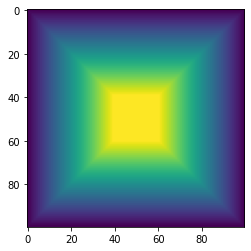

In [ ]:
weights = PyramidWeights(0.8, 100, 100).prob_weights
plt.imshow(weights)

In [ ]:
class Predictor():
  def __init__(self, feature_processor, config, network):
    self.config = config
    self.feature_processor = feature_processor
    self.network = network

  def predict_all(self):
    config = self.config
    network_config = config['network_config']
    dataset = self.feature_processor.process_all()

    pyramid_weights = PyramidWeights(config['eval_config']['pyramid_weights'], config['crop_size_x'], config['crop_size_y'])
    augmenter = DataAugmenter(config['crop_size_x'], config['crop_size_y'], network_config['binary_code_bits'], name='Features2D')

    num_bins=network_config['num_bins']

    threshold = 8.0 # Find the bin that is 8A+
    # Note that this misuses the max_range as the range.
    bin_with_threshold = int(threshold - float(network_config['min_range']) * num_bins / float(network_config['max_range']))
    for protein_batch in dataset.batch(1): 
      length = protein_batch.length[0]
      crop_count = 0
      prob_accum = np.zeros([length, length])
      weight_accum = np.zeros([length, length])
      softmax_prob_accum = np.zeros([length, length, num_bins], dtype=np.float32)
      cropper = Cropper(config, protein_batch)
      crop_count_estimate = cropper.get_crop_count()
      print(f'Processing example with length: {length}, Number of crops: {crop_count_estimate}')
      for crop in cropper:
        # Convert crop to "batch style"
        crop_x = tf.constant([crop.rectangle.x, crop.rectangle.end_x], dtype=tf.int32, shape=[1, 2])
        crop_y = tf.constant([crop.rectangle.y, crop.rectangle.end_y], dtype=tf.int32, shape=[1, 2])
            
        augmentation_features = augmenter(protein_batch.inputs_1d, crop.inputs_2d, protein_batch.residue_indices, crop_x, crop_y)

        # Todo: run network; for now simulate the nework output
        activations = self.network(augmentation_features, crop.rectangle.size_x, crop.rectangle.size_y)

        softmax_prob = tf.nn.softmax(activations[0, :, :, :num_bins])
        prob = tf.reduce_sum(softmax_prob[:, :, :bin_with_threshold], axis=2)

        weight = crop.get_live_data_hw(pyramid_weights.prob_weights)
        
        prob = crop.get_live_data_hw(prob)
        softmax_prob = crop.get_live_data_hwc(softmax_prob)

        prob *= weight
        softmax_prob *= tf.expand_dims(weight, axis=2)

        crop.stitch_data_onto_hw(prob, prob_accum)
        crop.stitch_data_onto_hw(weight, weight_accum)
        crop.stitch_data_onto_hwc(softmax_prob, softmax_prob_accum)

        crop_count += 1
      assert (weight_accum > 0.0).all()

      probs = prob_accum / weight_accum
      softmax_probs = softmax_prob_accum / tf.expand_dims(weight_accum, axis=2)
      plt.imshow(softmax_probs[:, :, 1])

      # The probs are symmetrical.
      probs = (probs + probs.transpose()) / 2
      if num_bins > 1:
        softmax_probs = (softmax_probs + np.transpose(softmax_probs, axes=[1, 0, 2])) / 2

      break

Processing example with length: 128, Number of crops: 256


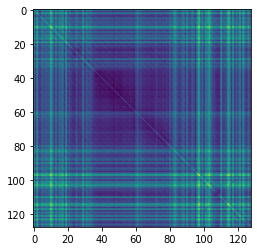

In [ ]:
feature_processor = FeatureProcessor(config, tf_record_filename, stats_file_path)

def one_network(unused_inputs, crop_size_x, crop_size_y):
  prob = tf.constant(1, shape=[1, crop_size_y, crop_size_x, network_config['num_bins']], dtype=tf.float32)
  return prob

def avg_network(inputs, crop_size_x, crop_size_y):
  prob = tf.constant(1, shape=[1, crop_size_y, crop_size_x, network_config['num_bins']], dtype=tf.float32)
  prob = prob + tf.pad(tf.math.reduce_mean(inputs, axis=3, keepdims=True), [[0,0], [0,0],[0,0], [0,network_config['num_bins'] - 1]])
  return prob

predictor = Predictor(feature_processor, config, avg_network)
predictor.predict_all()


Run evaluation

In [ ]:
# Load the saved model weights
saved_model_path = 'alphafold-casp13-weights/873731/0/tf_graph_data/tf_graph_data.ckpt'

checkpoint = tf.train.Checkpoint() # TODO: pass in model
restore_status = checkpoint.restore(saved_model_path)
# TODO: restore status validation (see https://www.tensorflow.org/guide/checkpoint#loading_mechanics)

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Load weights using the checkpoint. The weights were saved with v1 of tensorflow with sonnet (the `Saver`). This data can be loaded with TF v2's `Checkpoint`. This successfully loads them, but we need to apply the weights to the modle later. There are also some functions to validate that the restore applies the correct variables we can implment later